> ### EEE4423: Deep Learning Lab

# LAB \#11: Character Generation using LSTM

<h4><div style="text-align: right"> Due date: May 20, 2022. </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab11.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).

<h2><span style="color:blue">[201714216] [이관희]</span> </h2>

In [1]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2022-05-19 00:39:51.082236


In [2]:
!pip install unidecode --user

You should consider upgrading via the '/home/jovyan/.venv/torch1.9.0-py3.8-cuda11.1/bin/python -m pip install --upgrade pip' command.


In [3]:
import unidecode
import string
import random
import re
import os

import torch
import torch.nn as nn
from torch.autograd import Variable

These sorts of generative models form the basis of machine translation, image captioning, question answering and more.

<img src="http://drive.google.com/uc?export=view&id=16E7HG_dCyfTo9u9qrrhp2eClq6xK6-f_" style="width: 600px;"/>

### 1. Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package

<img src="http://drive.google.com/uc?export=view&id=171lX3vxj60AQNScQi872BHx2Rz6J7-3J" />

In [4]:
# 파일 불러오기 
file = unidecode.unidecode(open('../dataset/lab11/lose_yourself_eminem.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 4063


To make inputs out of this big string of data, we will be splitting it into chunks.

In [5]:
chunk_len = 200

# train과 test에서 사용할 data가 매우 길이가 제각각이므로 이를 일정하게 만드는 역할이다.
# 아래 출력값의 글자수가 200이되는 것이다.
def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    # print(start_index)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())
print('\n')
print(len(random_chunk()))

chmo who flows, he nose dove and sold nada
So the soap opera is told and unfolds, I suppose it's old partna, but the beat goes on
Da da dumb da dumb da da
You better lose yourself in the music, the mom


201


Each chunk will be turned into a tensor by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [6]:
# Turn string into list of longs
# 출력가능한 모든 문자를 살펴보자
# 여기서 만약 one-hot-vector로 전환한다면 dimension의 크기와 같은 값일 것이다.
all_characters = string.printable
n_characters = len(all_characters)
print(all_characters)
print('\n')
print('num_chars = ', n_characters)
# 총 올수 있는 문자의 종류는 100개이다.

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



num_chars =  100


In [7]:
# 문자열을 input으로 받는다면 그 값을 위에 printable에 해당하는
# index tensor로 바꿔주는 역할을 한다. 
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print('abcDEF is changed to ', char_tensor('abcDEF'))

abcDEF is changed to  tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [8]:
# love_yourself 가사를 적절하게 자르고 이를
# train data와 test data로 나누는 작업이다.
def random_training_set():    
    chunk = random_chunk()
    # print(len(chunk)) # 201 이다 왜냐하면 {end-start}(200)+1을 해야 되므로 
    inputs = char_tensor(chunk[:-1])
    #print(inputs.size()) torch.Size([200])
    targets = char_tensor(chunk[1:])
    #print(targets.size()) torch.Size([200])
    return inputs, targets

In [9]:
inputs , targets =random_training_set()
print(inputs)
print(targets)
# 여기서 학습 방법을 파악해야 한다. inputs의 하나씩 넣은 output 값과 target값을 cross entropy 취해서 학습시켜준다.

tensor([16, 14, 96, 37, 30, 29, 94, 44, 94, 20, 14, 25, 29, 94, 27, 17, 34, 22,
        18, 23, 68, 94, 10, 23, 13, 94, 28, 29, 14, 25, 32, 27, 18, 29, 18, 23,
        68, 94, 29, 17, 14, 94, 23, 14, 33, 29, 94, 12, 18, 25, 17, 14, 27, 96,
        37, 14, 28, 29, 94, 11, 14, 21, 18, 14, 31, 14, 94, 28, 24, 22, 14, 11,
        24, 13, 34, 68, 28, 94, 25, 10, 34, 18, 23, 68, 94, 29, 17, 14, 94, 25,
        18, 14, 13, 94, 25, 18, 25, 14, 27, 96, 36, 21, 21, 94, 29, 17, 14, 94,
        25, 10, 18, 23, 94, 18, 23, 28, 18, 13, 14, 94, 10, 22, 25, 21, 18, 15,
        18, 14, 13, 94, 11, 34, 94, 29, 17, 14, 96, 41, 10, 12, 29, 94, 29, 17,
        10, 29, 94, 44, 94, 12, 10, 23, 68, 29, 94, 16, 14, 29, 94, 11, 34, 94,
        32, 18, 29, 17, 94, 22, 34, 94, 23, 18, 23, 14, 94, 29, 24, 96, 41, 18,
        31, 14, 94, 10, 23, 13, 94, 44, 94, 12, 10, 23, 68, 29, 94, 25, 27, 24,
        31, 18])
tensor([14, 96, 37, 30, 29, 94, 44, 94, 20, 14, 25, 29, 94, 27, 17, 34, 22, 18,
        23, 68, 94, 10,

In [10]:
inputs[0]

tensor(16)

### 2. Build the LSTM model [4 points]

#### [Diagram of LSTM]
<img src="http://drive.google.com/uc?export=view&id=1baQ6Ffu-vDcXbOEBYGeLzhmfvaj4DGgW" style="width: 800px;"/>
LSTM consists of cell state, hidden state and 3 gates that modify or use the cell state. The cell state is the key part of the LSTM and you can think that information "flows" in there. The operation of 3 gates are described in below.

#### [Forget Gate]
The forget gate determines which information in the cell state should be erased.
<img src="http://drive.google.com/uc?export=view&id=1sJisl5P0hggmvH4qrcYgSETFKdFdBSH_" style="width: 600px;"/>

#### [Input Gate]
First, the candidate cell state is created using the current input and the previous hidden state. And the input gate determines how much the candidate cell state is reflected to the cell state.
<img src="http://drive.google.com/uc?export=view&id=1Df-k5FORGH7PnXauYcb8qqUpY3Uot9A7" style="width: 600px;"/>

#### [Output Gate]
The output gate determines which elements should be extracted from the cell state to produce the output.
<img src="http://drive.google.com/uc?export=view&id=1JLCGPcrZLOYfjyJhMTvmfixHq5plFj8L" style="width: 600px;"/>

The above expression is summarized as follows,
<img src="http://drive.google.com/uc?export=view&id=1kGq8DwwzizuNcg6GF0GaP1DAu26FFlrB" style="width: 300px;"/>


This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one LSTM layer that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [ ]:
# RNN 구조를 한번 파악해보자. 이걸 알아야 embedding이 어떻게 쓰이는지 파악할 수 있다.

'''
STEP 3: CREATE MODEL CLASS
'''
class RNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.embedding_size = hidden_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        # encoder layer인 embedding이 이 함수의 핵심이다.
        # https://wikidocs.net/64779 사이트를 참고하자.
        # 간단히 말하면 nn.Embedding()을 사용하여 학습가능한 임베딩 테이블을 만드는 것이다.
        # 학습 부분을 보면 알겠지만 하나의 element를 조금 변형해서 넣어주는 것 뿐이 없다.
        # 즉 embedding은 table을 만드는 함수로 one-hot-encoding 대신 사용할 수 있는 학습 테이블 이라고 보면 된다.
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)
        self.rnn = nn.RNN(self.embedding_size,self.hidden_size,self.num_layers)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        
    
    def forward(self, input, hidden):
        # print(input.dtype) # torch.int64
        out = self.encoder(input.view(1,-1))
        out,hidden = self.rnn(out,hidden)
        # print(out.size()) # torch.Size([1, 1, 100])
        out = self.decoder(out.view(batch_size,-1))
        #print(out.size()) # torch.Size([1, 100])
        return out,hidden

    def init_hidden(self):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return hidden

hidden_size=100
num_layers = 1
batch_size = 1
    
model = RNN(n_characters, hidden_size, hidden_size, n_characters, num_layers)
# model = LSTMModel(n_characters, hidden_dim, n_layers, n_characters)
model.cuda()

In [ ]:
# 이 코드를 이용해서 밑에 내 코드가 잘 짜야져있는지 확인해보자. 
class LSTM(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(self.input_size, self.embedding_size)
        self.rnn = nn.LSTM(self.embedding_size,self.hidden_size,self.num_layers)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        
    
    def forward(self, input, hidden, cell):
        out = self.encoder(input.view(1,-1))
        out,(hidden,cell) = self.rnn(out,(hidden,cell))
        out = self.decoder(out.view(batch_size,-1))
        return out,hidden,cell

    def init_hidden(self):
        hidden = torch.zeros(self.num_layers,batch_size,self.hidden_size)
        cell = torch.zeros(self.num_layers,batch_size,self.hidden_size)
        return hidden,cell

hidden_size = 100
num_layers = 1
n_characters = len(all_characters)
embedding_size=70 
batch_size = 1


model = LSTM(n_characters, embedding_size, hidden_size, n_characters, num_layers)
model.cuda()

In [48]:
## 내가 짠 모델이다.

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        
        self.encoder = nn.Embedding(input_dim, hidden_dim)
        
        # lstm
        # The size of input is (batch_size, seq_dim, hidden_dim)
        # 위에께 들어오는지 알았는데 forword에 들어올 input은 그냥 하나의 tensor이다. 이걸 embedding을 통해서
        # 학습가능한 형태의 table로 만들어줘야 하는 것이다. 여기서 input_dim = 100 이고 hidden_dim=100이다.
        # 즉 100 x 100의 table을 만든것이다.여기서 encoder

        
        # x size [1] embedding -> [1,100(word의 갯수),100(알바벳 갯수)]
        # h size [B,S,C] -> [1,100,100]
        # x와 h concatnate 한 size [1,100,200]
        # concatnate 못함 왜냐 [1,100,100] 유지해야 되는데 [1,100,200]으로 계산 못함.
        # 고로 더하기로 구현하자.
        # torch.cat((x, h), 3)
        
        # forget_gate
        self.forget_gate = nn.Linear(hidden_dim, hidden_dim)
        
        #input_gate
        self.input_gate_i = nn.Linear(hidden_dim, hidden_dim)
        self.input_gate_C = nn.Linear(hidden_dim, hidden_dim)
        
        ##output_gate
        self.output_gate = nn.Linear(input_dim,hidden_dim)

        self.sigmoid = nn.Sigmoid()
        
        self.tanh = nn.Tanh()

        self.decoder = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, input, hn, cn):
        #############
        # CODE HERE #
        #############
#         print('input : {}'.format(input.size()))
#         print('hn : {}'.format(hn.size()))
        x = self.encoder(input.view(1,-1)) # x size 1 , 1 -> 1,1,100
        # print(x.size())
#         print('x : {}'.format(x.size()))
        
        ## forget Gate
        f_t=self.sigmoid(self.forget_gate(x)+self.forget_gate(hn)) # [1,1,100]
#         print(f_t.size())
        # f_t size [B,hidden_dim]
        
#         ## 질문 forget gate에서 같은 layer을 의미하는가? ㅇㅇ 공유함. 식이 같음.
#         hidden_1= self.forget_gate_input(input) + self.forget_gate_h(hn)
#         hidden_1 = self.sigmoid(hidden_1)
        
        ## input gate
        i_t=self.sigmoid(self.input_gate_i(x)+self.input_gate_i(hn))      #[1,1,100]  
        tillde_C = self.tanh(self.input_gate_C(x)+self.input_gate_C(hn)) # [1,1,100]
        
        ## cn 업데이트
        cn = cn*f_t+i_t*tillde_C # [1,1,100]
#         print(cn.size())
        
        ## output gate
        o_t = self.sigmoid(self.output_gate(x)+self.output_gate(hn))
        h_t = o_t * self.tanh(cn)
        
        # hn 업데이트
        hn = h_t # [1,1,100]
        
        ## 질문 output은 h_t와 같나? 다르다. 여기서 output은 decoder 해줘야함.
        output = self.decoder(h_t.view(1,-1)) # [1,100]
        return output, hn, cn

    def init_hidden(self):
        # The size of h0, c0 should be (layer_dim, batch_size, hidden_dim)
        #############
        # CODE HERE #
        #############
        h0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim).cuda()) # initial hidden state [1,1,100]
        c0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim).cuda()) # initial cell state [1,1,100]
        
        return h0, c0
    
hidden_dim = 100
n_layers = 1
n_characters = len(all_characters)

model = LSTMModel(n_characters, hidden_dim, n_layers, n_characters)
model.cuda()

LSTMModel(
  (encoder): Embedding(100, 100)
  (forget_gate): Linear(in_features=100, out_features=100, bias=True)
  (input_gate_i): Linear(in_features=100, out_features=100, bias=True)
  (input_gate_C): Linear(in_features=100, out_features=100, bias=True)
  (output_gate): Linear(in_features=100, out_features=100, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)

In [11]:
## 위에꺼는 x와 h의 parameter가 같다. 그래서 이게 맞는 모델이다.

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.output_dim = output_dim
        
        self.encoder = nn.Embedding(input_dim, hidden_dim)
        
        # lstm
        # The size of input is (batch_size, seq_dim, hidden_dim)
        # 위에께 들어오는지 알았는데 forword에 들어올 input은 그냥 하나의 tensor이다. 이걸 embedding을 통해서
        # 학습가능한 형태의 table로 만들어줘야 하는 것이다. 여기서 input_dim = 100 이고 hidden_dim=100이다.
        # 즉 100 x 100의 table을 만든것이다.여기서 encoder

        
        # x size [1] embedding -> [1,100(word의 갯수),100(알바벳 갯수)]
        # h size [B,S,C] -> [1,100,100]
        # x와 h concatnate 한 size [1,100,200]
        # concatnate 못함 왜냐 [1,100,100] 유지해야 되는데 [1,100,200]으로 계산 못함.
        # 고로 더하기로 구현하자.
        # torch.cat((x, h), 3)
        
        # forget_gate
        self.forget_gate_x = nn.Linear(hidden_dim, hidden_dim)
        self.forget_gate_h = nn.Linear(hidden_dim, hidden_dim)

        #input_gate
        self.input_gate_i_x = nn.Linear(hidden_dim, hidden_dim)
        self.input_gate_i_h = nn.Linear(hidden_dim, hidden_dim)

        self.input_gate_C_x = nn.Linear(hidden_dim, hidden_dim)
        self.input_gate_C_h = nn.Linear(hidden_dim, hidden_dim)

        
        ##output_gate
        self.output_gate_x = nn.Linear(input_dim,hidden_dim)
        self.output_gate_h = nn.Linear(input_dim,hidden_dim)

        self.sigmoid = nn.Sigmoid()
        
        self.tanh = nn.Tanh()

        self.decoder = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, input, hn, cn):
        #############
        # CODE HERE #
        #############
#         print('input : {}'.format(input.size()))
#         print('hn : {}'.format(hn.size()))
        x = self.encoder(input.view(1,-1)) # x size 1 , 1 -> 1,1,100
        # print(x.size())
#         print('x : {}'.format(x.size()))
        
        ## forget Gate
        f_t=self.sigmoid(self.forget_gate_x(x)+self.forget_gate_h(hn)) # [1,1,100]
#         print(f_t.size())
        # f_t size [B,hidden_dim]
        
#         ## 질문 forget gate에서 같은 layer을 의미하는가? ㅇㅇ 공유함. 식이 같음.
#         hidden_1= self.forget_gate_input(input) + self.forget_gate_h(hn)
#         hidden_1 = self.sigmoid(hidden_1)
        
        ## input gate
        i_t=self.sigmoid(self.input_gate_i_x(x)+self.input_gate_i_h(hn))      #[1,1,100]  
        tillde_C = self.tanh(self.input_gate_C_x(x)+self.input_gate_C_h(hn)) # [1,1,100]
        
        ## cn 업데이트
        cn = cn*f_t+i_t*tillde_C # [1,1,100]
#         print(cn.size())
        
        ## output gate
        o_t = self.sigmoid(self.output_gate_x(x)+self.output_gate_h(hn))
        h_t = o_t * self.tanh(cn)
        
        # hn 업데이트
        hn = h_t # [1,1,100]
        
        ## 질문 output은 h_t와 같나? 다르다. 여기서 output은 decoder 해줘야함.
        output = self.decoder(h_t.view(1,-1)) # [1,100]
        
        return output, hn, cn

    def init_hidden(self):
        # The size of h0, c0 should be (layer_dim, batch_size, hidden_dim)
        #############
        # CODE HERE #
        #############
        h0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim).cuda()) # initial hidden state [1,1,100]
        c0 = Variable(torch.zeros(self.layer_dim, 1, self.hidden_dim).cuda()) # initial cell state [1,1,100]
        
        return h0, c0
    
hidden_dim = 100
n_layers = 1
n_characters = len(all_characters)

model = LSTMModel(n_characters, hidden_dim, n_layers, n_characters)
model.cuda()

LSTMModel(
  (encoder): Embedding(100, 100)
  (forget_gate_x): Linear(in_features=100, out_features=100, bias=True)
  (forget_gate_h): Linear(in_features=100, out_features=100, bias=True)
  (input_gate_i_x): Linear(in_features=100, out_features=100, bias=True)
  (input_gate_i_h): Linear(in_features=100, out_features=100, bias=True)
  (input_gate_C_x): Linear(in_features=100, out_features=100, bias=True)
  (input_gate_C_h): Linear(in_features=100, out_features=100, bias=True)
  (output_gate_x): Linear(in_features=100, out_features=100, bias=True)
  (output_gate_h): Linear(in_features=100, out_features=100, bias=True)
  (sigmoid): Sigmoid()
  (tanh): Tanh()
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)

### 3. Loss function and optimizer

In [12]:
criterion = nn.CrossEntropyLoss()

lr = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 4 . Write the character level generation code [4 points]

- Generate a sentence with a length of $predict\_len$, starting from a single character $prime\_str$.
- Example) evaluate(prime_str='Y', predict_len=20) -> You better let it go

In [13]:
def evaluate(prime_str='W', predict_len=20):
    inp = char_tensor(prime_str)
    # print(inp) # tensor([58])
    hidden, cell = model.init_hidden() # 이미 cuda() 올라가 있음.
    x = inp.cuda()
#     model.cpu()

#     print(' W : {}'.format(prime_input))
    print(prime_str,end="")
    
    for p in range(predict_len):
        output,hidden, cell= model(x,hidden, cell)
        #print(output.data.view(-1)) # torch.Size([100])
        #print(output.data.view(-1).div(0.8))
        #print(output.data.view(-1).div(0.8).exp())
        output_dist = output.data.view(-1).div(0.8).exp()
        # output.data.view(-1).div(0.8) output 값을 0.8로 나누는 것이다.
        # 그 후 exp()를 씌한다.
        # 즉 out_dist에서 얻어진 값이 확률로 해석될 수 있는 텐서가 된다.
        # multinomial의 첫번쨰 인자는 확률로 해석될 수 있는 텐서가 들어가고
        # 두번째 인자는 샘플링할 갯수가 들어간다.
        top_i = torch.multinomial(output_dist, 1)[0]
        predicted_char = all_characters[top_i]
        
        print(predicted_char,end="")
        
        x = char_tensor(predicted_char).cuda()
        # x를 계속해서 쓰기 때문에 x를 업데이트 해주면 된다. output으로 원래는 predicted 였지만 의미 없으므로
        # return 값이 없어도 된다. 그러나 여기서는 보내야 된다면 그냥 predicted_char 를 보면 될 것 같다.
        # 근데 출력이 안 예쁘므로 그냥 생략하자.
    #predicted = predicted_char
    #return predicted
    # -> 이걸 print에서 쓸 것이기 때문에 이렇게하면 none 이 출력된다. 그러므로 문자열을 만들어 주자.

In [14]:
def evaluate(prime_str='W', predict_len=20):
    inp = char_tensor(prime_str)
    hidden, cell = model.init_hidden() # 이미 cuda() 올라가 있음.
    x = inp.cuda()
    predicted = str()
    predicted = predicted + prime_str
    
    for p in range(predict_len):
        output,hidden, cell= model(x,hidden, cell)
        #print(output.data.view(-1)) # torch.Size([100])
        #print(output.data.view(-1).div(0.8))
        #print(output.data.view(-1).div(0.8).exp())
        output_dist = output.data.view(-1).div(0.8).exp()
        # output.data.view(-1).div(0.8) output 값을 0.8로 나누는 것이다.
        # 그 후 exp()를 씌한다.
        # 즉 out_dist에서 얻어진 값이 확률로 해석될 수 있는 텐서가 된다.
        # multinomial의 첫번쨰 인자는 확률로 해석될 수 있는 텐서가 들어가고
        # 두번째 인자는 샘플링할 갯수가 들어간다.
        top_i = torch.multinomial(output_dist, 1)[0]
        predicted_char = all_characters[top_i]
        
        predicted = predicted + predicted_char
        
        x = char_tensor(predicted_char).cuda()
        # x를 계속해서 쓰기 때문에 x를 업데이트 해주면 된다. output으로 원래는 predicted 였지만 의미 없으므로
        # return 값이 없어도 된다. 그러나 여기서는 보내야 된다면 그냥 predicted_char 를 보면 될 것 같다.
        # 근데 출력이 안 예쁘므로 그냥 생략하자.
    #predicted = predicted_char
    return predicted

In [17]:
print(evaluate())

WT?c
8*':c=F5)QLhf6


In [18]:
weights = torch.tensor([0, 40, 5, 10, 3, 0], dtype=torch.float) # create a tensor of weights
print(torch.multinomial(weights, 1))
print(torch.multinomial(weights, 1))
print(torch.multinomial(weights, 1))
print(torch.multinomial(weights, 1))
print(torch.multinomial(weights, 1))
print(torch.multinomial(weights, 1))
print(torch.multinomial(weights, 1))
print(torch.multinomial(weights, 1))
print(torch.multinomial(weights, 1))
print(torch.multinomial(weights, 1))
print(torch.multinomial(weights, 1))
print(torch.multinomial(weights, 1))
# 확률적으로 추출하게 됨. 

tensor([1])
tensor([3])
tensor([2])
tensor([1])
tensor([3])
tensor([4])
tensor([2])
tensor([3])
tensor([1])
tensor([1])
tensor([3])
tensor([1])


### 5 . Write the code to train the model [2 points]

- Plot the training loss curve.
- Print the output sentence with a length of 100, using $evaluate()$ function.

In [19]:
input = torch.randn(3, 5, requires_grad=True)
print(input)
target = torch.randn(3, 5).softmax(dim=1)
print(target)
target = torch.empty(3, dtype=torch.long).random_(5)
print(target)

tensor([[-1.0292,  0.0758,  0.1664, -0.1592,  1.1450],
        [-0.2130,  1.1669, -0.5697,  0.7416,  1.6917],
        [-2.0640,  0.9690, -0.5804, -0.4183, -0.1007]], requires_grad=True)
tensor([[0.0221, 0.2437, 0.2246, 0.4075, 0.1021],
        [0.0814, 0.0364, 0.3158, 0.4135, 0.1529],
        [0.0263, 0.0243, 0.0490, 0.8479, 0.0525]])
tensor([3, 0, 2])


In [20]:
n_epochs = 2000
print_every = 100
plot_every = 10

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    # Load text
    inputs, targets = random_training_set()
    if inputs.size()[0] < 200: continue
    
#     print(inputs)
#     print(targets)
    
    # 다 gpu로 올리고 최기화 해주자.  # Clear gradients w.r.t. parameters    
    hidden , cell = model.init_hidden()
    inputs = inputs.cuda()
    targets = targets.cuda()
    model.zero_grad()
    optimizer.zero_grad()
    
    # Forward pass
    loss = torch.tensor([0]).type(torch.FloatTensor) # 0으로 해도됨.
    for j in range(chunk_len-1):
        x  = inputs[j]
#         print(x)
        y_ = targets[j].unsqueeze(0).type(torch.LongTensor)
        y,hidden, cell = model(x,hidden,cell)
#         print(y.size())
#         print(y_.size())
        y= y.cpu()
        loss += criterion(y,y_)
#         print(loss)

        
    # Backward pass
    loss.backward()
    
    # Updating parameters
    optimizer.step()

    loss_avg += loss.item() / chunk_len
    
    if epoch % print_every == 0:
        print('*'*25, 'epoch%d'%epoch, '*'*25)
        print('loss %.4f'%loss.item())
        print(evaluate('I', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


************************* epoch100 *************************
loss 286.2765
Is better is onay molity woreve hall wonis to mut ne tis whanly knorlld mife moss get lor therer cohe 

************************* epoch200 *************************
loss 326.7842
IMBat fot her blows thater and
An't on anly litt
Or momely coke a dot, Note lity doment ever walk a b 

************************* epoch300 *************************
loss 357.5076
Ighis opine do no I sombflive the won't pain' and ppime you but better un in a is on in ied ast do fa 

************************* epoch400 *************************
loss 282.1879
I nore not ma ling cinge, the mes only mo not ma fargtter jagn li to ceass grome to plo stermbe raily 

************************* epoch500 *************************
loss 265.4240
I only faybu beter one shot, but I't spot, don't and to not miss youred and rage
Ted is you better
Th 

************************* epoch600 *************************
loss 224.0096
I't wore tardod
He colily tho 

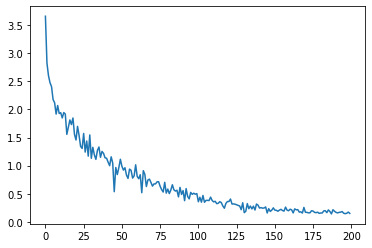

In [21]:
# 0~2000epoch
#################################################
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(all_losses)

### *References*
[1] [practical pytorch](https://github.com/spro/practical-pytorch)(https://github.com/spro/practical-pytorch)

[2] [CS 231n](http://cs231n.stanford.edu/syllabus.html)(http://cs231n.stanford.edu/syllabus.html)

이 실험은 NLP의 기본이 되는 모델인 RNN과 LSTM을 분석하는 것이다. RNN은 과거의 정보를 바탕으로 현재를 추정하는 sequence task에 잘 잘동한다. 하지만 long-term 일 경우에는 이론상으로는 가능하지만 gradient vanshing 문제 등이 겹치면서 실제적으로는 잘 작동하지 않는다. 이를 보안하기 위해 만들어진 모델이 LSTM이다. LSTM은 gate를 이용해서 과거의 정보를 얼마나 상쇄시킬것이고 현재의 정보을 얼마나 추가해줄 것인지를 결정하기 때문에 매우 유용하다. 자세한 설명은 예비보고서에서 했으니 생략하겠지만 핵심은 LSTM을 사용했을 때 위의 가사와 같은 문제와 같은 sequence 문제같은 NLP 관련 task를 해결할 수 있다는 것이다.

예상했던 점 : RNN과 LSTM 모두 반복적인 구조를 이용해서 recurrent하게 학습이 진행되어 sequence task를 수행할 수 있다.
    이를 확인하기 위해서 먼저 MNIST dataset을 가지고 분석하였다. MNIST dataset의 28x28을 한 줄씩 sequence로 보아서 
    RNN과 LSTM모두 넣어준 결과 각 image가 무엇을 뜻하는 것인지 94~95% 육박하는 성능을 보였다. 따라서 RNN 구조는 매우
    효과적인 구조라고 볼 수 있다.
    
예상과 달랐던 점 및 개선할 점 : 
input이 element가 1개인 tensor인데 학습이 이루어지는 것이 처음는 너무 이해가 가지 않았다. 그래서 질문도 했지만 뭐가 이해않되고 있는지도 모르고 개념이 전체가 잘못 잡혀있어서 아쉬웠다. 그렇게 검색을 하던 중에 RNN으로 관련 task를 진행한 사이트를 찾을 수 있었고 그 사이트에서 embedding table을 이해할 수 있었다. (위에 링크가 주석으로 되어 있다.)

 위의 결과를 보면 알 수 있듯이 Loss 값은 계속 주는 것으로보아 학습이 이루어 지고 있다는 것을 알 수 있다. 출력되는 문자열 역시 가사를 잘 모르지만 이해할 수 있는 알파벳 순서로 나열되어 그럴듯한 결과를 얻을 수 있었다. 여기서 파악할 수 있는 것은 
노래 가사라는 짧은 글에 task를 학습하기 위해서 2000 epoch 정도가 필요했다. 사실상 이건 overfitting된 값이기 때문에 가사에 매우 잘 fit한 것으로 볼 수 있지만 (사실상 복사에 가까운 개념이 아닐까?) 실제로는 단어와 문장이 매우 다양하기 때문에 좀 더 명확한 분석이 필요할 것이다. 이를 위해서는 더 큰 data set으로 예상해봐야 할 것 같다.

결론 : LSTM과 RNN을 살펴봄을써 NLP 모델의 기초를 학습할 수 있었다. 그리고 embedding table를 이용해서 한 단어를 embedding하여 학습이 가능하다는 것을 깨달을 수 있었다. 
    
의문점 : 블로그에서 소개하길 LSTM의 다음 step이 attention이라고 했는데 이는 어떤 것을 추가해서 성능을 업그레이드 했는지 궁금하다.

https://wjddyd66.github.io/pytorch/Pytorch-RNN&LSTM/ 를 주로 참고하였음